In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, 
                          Dropout, Input, GlobalAveragePooling2D, BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, accuracy_score)
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import os
# Corrected imports section (at the top of your notebook)
from tensorflow.keras.applications import VGG19  # Add this import
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, InceptionV3




In [2]:
# Define the paths and classes for the new dataset
base_path = "/kaggle/input/acne-psoriasis-eczema-dataset/Acne_Psoriasis_Eczema_Dataset/"
classes = ["1. Eczema 1677", "ACNE", "Psoriasis"]  # Order determines label assignment

def data_dictionary():
    train_dictionary = {"image_path": [], "target": []}
    
    for label_idx, class_name in enumerate(classes):
        class_path = os.path.join(base_path, class_name)
        image_files = os.listdir(class_path)
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            train_dictionary["image_path"].append(img_path)
            train_dictionary["target"].append(label_idx)  # Assign 0, 1, 2
            
    train_df = pd.DataFrame(train_dictionary)
    return train_df

train = data_dictionary()

In [3]:
# Load and preprocess images
# Load and preprocess images with error handling
images = []
labels = []
problematic_files = []

for idx, img_path in enumerate(train['image_path']):
    try:
        # Verify file exists
        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            problematic_files.append(img_path)
            continue
            
        # Read image
        img = cv2.imread(img_path)
        
        # Check if image was read properly
        if img is None:
            print(f"Could not read image: {img_path}")
            problematic_files.append(img_path)
            continue
            
        # Convert color space
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image
        img = cv2.resize(img, (180, 180))
        
        # Add to dataset
        images.append(img)
        labels.append(train['target'].iloc[idx])
        
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        problematic_files.append(img_path)

print(f"\nSuccessfully processed {len(images)} images")
print(f"Skipped {len(problematic_files)} problematic files")

# Convert to numpy arrays
data = np.array(images)
labels = np.array(labels)

Could not read image: /kaggle/input/acne-psoriasis-eczema-dataset/Acne_Psoriasis_Eczema_Dataset/1. Eczema 1677/desktop.ini
Could not read image: /kaggle/input/acne-psoriasis-eczema-dataset/Acne_Psoriasis_Eczema_Dataset/1. Eczema 1677/test
Could not read image: /kaggle/input/acne-psoriasis-eczema-dataset/Acne_Psoriasis_Eczema_Dataset/ACNE/desktop.ini
Could not read image: /kaggle/input/acne-psoriasis-eczema-dataset/Acne_Psoriasis_Eczema_Dataset/Psoriasis/desktop.ini

Successfully processed 16338 images
Skipped 4 problematic files


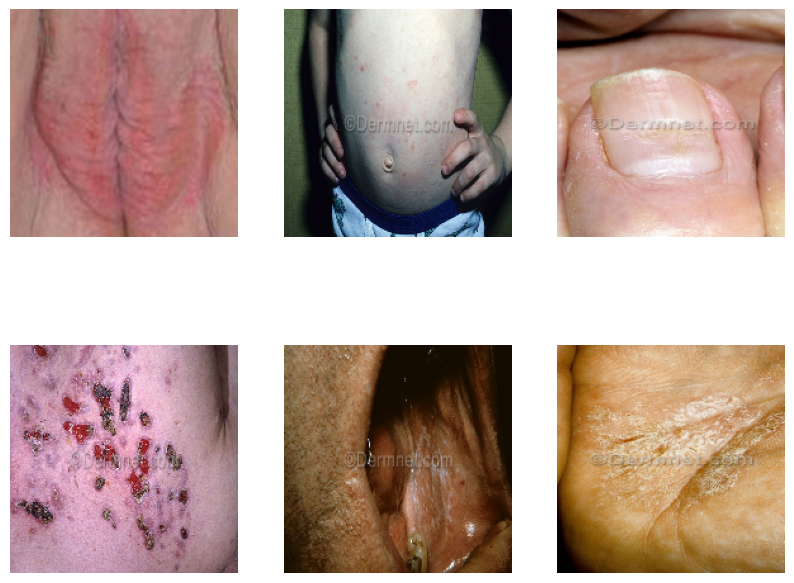

In [4]:
# Convert to numpy arrays
data = np.array(images)
labels = np.array(labels)

# Visualize sample images
example_list = random.sample(images, k=6)
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
for ax, img in zip(axes.ravel(), example_list):
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [5]:

# Build and compile the model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
for layer in vgg_model.layers:
    layer.trainable = False  # Freeze VGG19 layers

# Get number of features from VGG19 output
num_features = 5 * 5 * 512  # 12800 features (matches your error message)

model = Sequential([
    Dense(256, activation='relu', input_shape=(num_features,)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Convert labels to categorical (not needed if using sparse_categorical_crossentropy)
# labels = tf.keras.utils.to_categorical(labels, num_classes=3)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Extract features
def extract_features(images, model):
    features = model.predict(images, verbose=0)
    return features.reshape(features.shape[0], -1)

X_train_features = extract_features(X_train, vgg_model)
X_test_features = extract_features(X_test, vgg_model)

# Verify shapes
print("Training features shape:", X_train_features.shape)
print("Test features shape:", X_test_features.shape)

# Train the model
history = model.fit(X_train_features, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_data=(X_test_features, y_test),
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

Training features shape: (13070, 12800)
Test features shape: (3268, 12800)
Epoch 1/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5881 - loss: 4.2329 - val_accuracy: 0.7050 - val_loss: 0.6925
Epoch 2/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7274 - loss: 0.6465 - val_accuracy: 0.7240 - val_loss: 0.6397
Epoch 3/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7639 - loss: 0.5324 - val_accuracy: 0.7218 - val_loss: 0.6433
Epoch 4/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7855 - loss: 0.4690 - val_accuracy: 0.7399 - val_loss: 0.6226
Epoch 5/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8065 - loss: 0.4305 - val_accuracy: 0.7396 - val_loss: 0.6345
Epoch 6/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8189 - loss: 0.4130 - val_accuracy: 0.7347 - val_loss: 0.6398
Epoch 7/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8257 - loss: 0.3842 - val_accuracy: 0.7595 - val_loss: 0.6241
Epoch 8/15
409/409 ━━━━━━━━━━

In [7]:

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_features, y_test)
print(f"Test accuracy: {test_acc*100:.2f}%")


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7343 - loss: 0.6275
Test accuracy: 73.99%


In [8]:
# Confusion Matrix and Classification Report
y_pred = np.argmax(model.predict(X_test_features), axis=1)
cm = confusion_matrix(y_test, y_pred)


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


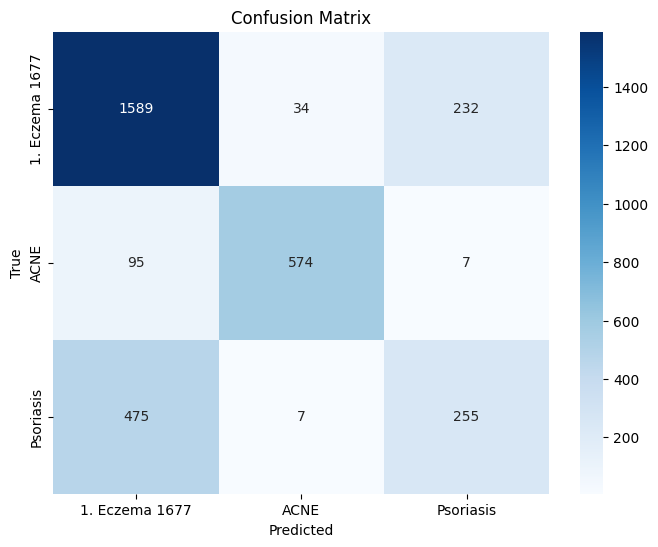

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, 
            yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classes))


                precision    recall  f1-score   support

1. Eczema 1677       0.74      0.86      0.79      1855
          ACNE       0.93      0.85      0.89       676
     Psoriasis       0.52      0.35      0.41       737

      accuracy                           0.74      3268
     macro avg       0.73      0.68      0.70      3268
  weighted avg       0.73      0.74      0.73      3268



In [11]:

# Save the model
model.save('skin_disease_vgg19.h5')

In [12]:
import os
print(os.listdir('.'))


['skin_disease_vgg19.h5', '__notebook__.ipynb']


In [13]:
import shutil
shutil.move('skin_disease_vgg19.h5', '/kaggle/working/skin_disease_vgg19.h5')


'/kaggle/working/skin_disease_vgg19.h5'